In [1]:
# Kaggle setup
!pip install kaggle

In [2]:
from google.colab import files
import os
import shutil

In [3]:
# Upload Kaggle API key
you_key = files.upload() # Upload kaggle.json


# Create Kaggle directory
kaggle_dir = os.path.join(os.path.expanduser('~'), '.kaggle')
os.makedirs(kaggle_dir, exist_ok=True)

Saving kaggle.json to kaggle.json


In [4]:
# Move kaggle.json file to the directory
shutil.move("kaggle.json", os.path.join(kaggle_dir, "kaggle.json"))
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Download Brain MRI dataset
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
# Unzip dataset
!unzip brain-mri-images-for-brain-tumor-detection.zip -d /content/brain_mri

Archive:  brain-mri-images-for-brain-tumor-detection.zip
replace /content/brain_mri/brain_tumor_dataset/no/1 no.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/brain_mri/brain_tumor_dataset/no/1 no.jpeg  
replace /content/brain_mri/brain_tumor_dataset/no/10 no.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/brain_mri/brain_tumor_dataset/no/10 no.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/brain_mri/brain_tumor_dataset/no/10 no.jpg  
  inflating: /content/brain_mri/brain_tumor_dataset/no/11 no.jpg  
  inflating: /content/brain_mri/brain_tumor_dataset/no/12 no.jpg  
  inflating: /content/brain_mri/brain_tumor_dataset/no/13 no.jpg  
  inflating: /content/brain_mri/brain_tumor_dataset/no/14 no.jpg  
  inflating: /content/brain_mri/brain_tumor_dataset/no/15 no.jpg  
  inflating: /content/brain_mri/brain_tumor_dataset/no/17 no.jpg  
  inflating: /content/brain_mri/brain_tumor_dataset/no/18 no.jpg  
  inflat

In [7]:
# --- Data Loading & Cleaning ---
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


base_path = '/content/brain_mri'
yes_path = os.path.join(base_path, 'yes')
no_path = os.path.join(base_path, 'no')


images, labels = [], []


def load_images_from_folder(folder, label):
  for filename in os.listdir(folder):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
      img_path = os.path.join(folder, filename)
      img = cv2.imread(img_path)
      if img is not None:
        img = cv2.resize(img, (128, 128))
        img = img / 255.0 # Normalize
        images.append(img)
        labels.append(label)
      else:
        print(f"Skipped corrupted file: {filename}")

load_images_from_folder(yes_path, 1)
load_images_from_folder(no_path, 0)


X = np.array(images)
y = np.array(labels)


print(f"Total Images: {len(X)}")
print(f"Tumor: {sum(y)}, No Tumor: {len(y) - sum(y)}")
print(f"Image Data Shape: {X.shape}")
print(f"Label Shape: {y.shape}")

Total Images: 253
Tumor: 155, No Tumor: 98
Image Data Shape: (253, 128, 128, 3)
Label Shape: (253,)


In [8]:
# --- Data Cleaning ---
# Remove any NaN or invalid entries
mask = np.array([not np.isnan(img).any() for img in X])
X = X[mask]
y = y[mask]


print(f"After Cleaning: {len(X)} valid images")

After Cleaning: 253 valid images


/tmp/ipython-input-789823652.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='Set2')


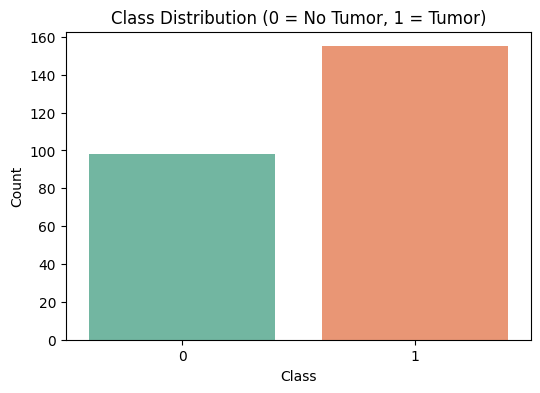

In [9]:
# --- Exploratory Data Analysis ---


# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y, palette='Set2')
plt.title('Class Distribution (0 = No Tumor, 1 = Tumor)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

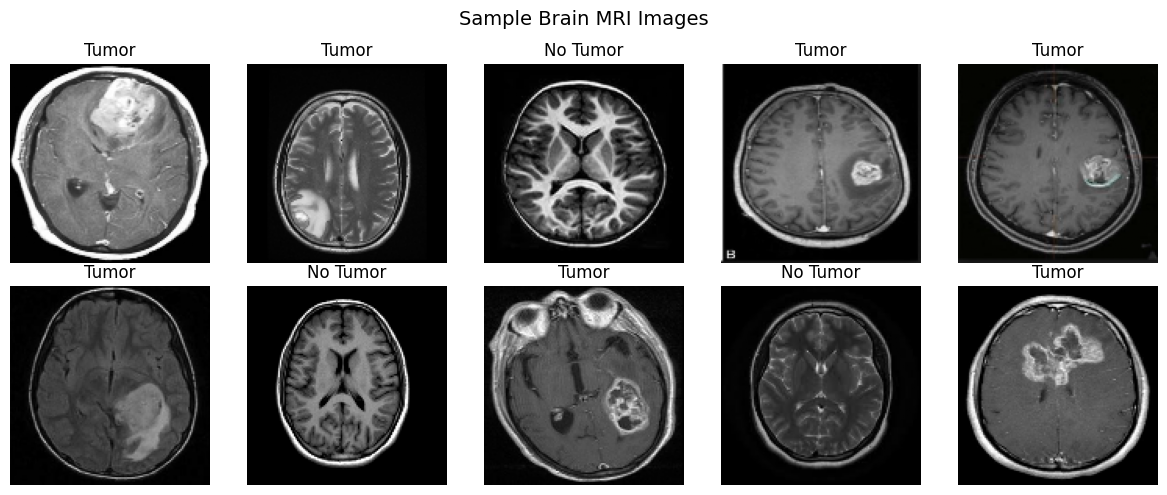

In [10]:
# Show random samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Sample Brain MRI Images', fontsize=14)
for i, ax in enumerate(axes.flat):
  idx = np.random.randint(0, len(X))
  ax.imshow(X[idx])
  ax.set_title('Tumor' if y[idx] == 1 else 'No Tumor')
  ax.axis('off')
plt.tight_layout()
plt.show()

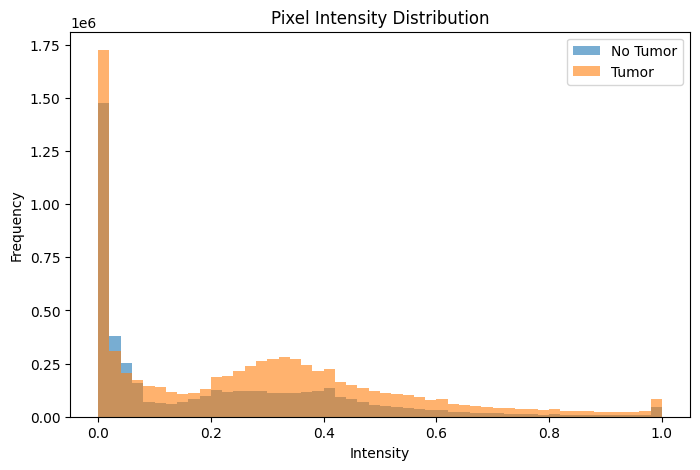

In [11]:


# Pixel intensity histogram
plt.figure(figsize=(8,5))
plt.hist(X[y==0].ravel(), bins=50, alpha=0.6, label='No Tumor')
plt.hist(X[y==1].ravel(), bins=50, alpha=0.6, label='Tumor')
plt.title('Pixel Intensity Distribution')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Average brightness - Tumor: 0.2759, No Tumor: 0.2038


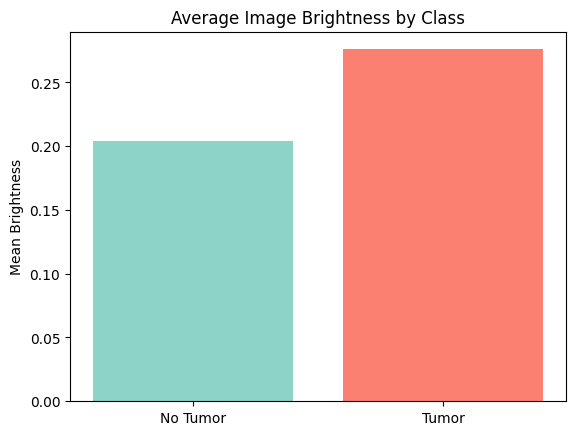

In [12]:
# Brightness comparison
mean_brightness_tumor = X[y==1].mean()
mean_brightness_no = X[y==0].mean()
print(f"Average brightness - Tumor: {mean_brightness_tumor:.4f}, No Tumor: {mean_brightness_no:.4f}")


plt.bar(['No Tumor', 'Tumor'], [mean_brightness_no, mean_brightness_tumor], color=['#8dd3c7', '#fb8072'])
plt.title('Average Image Brightness by Class')
plt.ylabel('Mean Brightness')
plt.show()

#Model Training

In [13]:
try:
    import torch
except ImportError:
    !pip install torch torchvision --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    auc,
)
from sklearn.preprocessing import label_binarize

import numpy as np
import matplotlib.pyplot as plt
import time

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


# Prepare PyTorch tensors from X, y

In [16]:
# X shape expected: (N, 128, 128, 3)
# y shape expected: (N,)

print("Original numpy shapes:", X.shape, y.shape)

X_torch = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)  # -> (N, 3, 128, 128)
y_torch = torch.tensor(y, dtype=torch.long)

X_train, X_val, y_train, y_val = train_test_split(
    X_torch,
    y_torch,
    test_size=0.2,
    random_state=42,
    stratify=y_torch,
)

train_ds = TensorDataset(X_train, y_train)
val_ds   = TensorDataset(X_val, y_val)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

class_names = ["No Tumor", "Tumor"]
num_classes = 2

print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}")

Original numpy shapes: (253, 128, 128, 3) (253,)
Train samples: 202, Val samples: 51


# Rough Fuzzy Optimizer

In [17]:
class RoughFuzzyOptimizer(optim.Optimizer):
    def __init__(self, params, lr=0.001, alpha=0.9, beta=0.5):
        """
        alpha: gradient norm threshold
        beta : scaling factor when grad is large
        """
        defaults = dict(lr=lr, alpha=alpha, beta=beta)
        super(RoughFuzzyOptimizer, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = closure() if closure is not None else None

        for group in self.param_groups:
            lr = group["lr"]
            alpha = group["alpha"]
            beta = group["beta"]

            for param in group["params"]:
                if param.grad is None:
                    continue

                grad = param.grad.data
                # Rough-fuzzy logic: adjust step based on gradient norm
                if torch.norm(grad) > alpha:
                    adjustment = beta * lr * grad
                else:
                    adjustment = lr * grad

                param.data -= adjustment

        return loss

# Metrics & Plot Utilities

In [25]:
def calculate_metrics(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    start_time = time.time()

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    inference_time = time.time() - start_time
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    return accuracy, precision, recall, f1, inference_time, all_labels, all_preds


def plot_confusion_matrix_from_labels(labels, preds, class_names, model_name):
    cm = confusion_matrix(labels, preds, labels=list(range(len(class_names))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()


def plot_training_curves(history, model_name):
    epochs = range(1, len(history["train_loss"]) + 1)

    # Loss curve
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, history["train_loss"], "r", label="Training Loss")
    plt.plot(epochs, history["val_loss"], "b", label="Validation Loss")
    plt.title(f"{model_name} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Accuracy curve
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, history["train_accuracy"], "r", label="Training Accuracy")
    plt.plot(epochs, history["val_accuracy"], "b", label="Validation Accuracy")
    plt.title(f"{model_name} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.show()


def plot_Binary_roc_curve(model, val_loader, device, num_classes, model_name):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Assume class 1 is "Tumor"
    y_true = all_labels
    y_score = all_probs[:, 1]   # probability of positive class
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.show()



Train & Validate Function

In [26]:
def train_and_validate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device, model_name):
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": [],
    }

    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        # ---------- Training ----------
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        # ---------- Validation ----------
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_accuracy"].append(train_accuracy)
        history["val_accuracy"].append(val_accuracy)

        print(
            f"Epoch [{epoch+1}/{num_epochs}] - {model_name} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%"
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss  # simple tracking like in file1

    return history

# Model definitions (ResNet, GoogleNet, MobileNet, VGG16, Alex net)

In [36]:
class ResNetModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetModel, self).__init__()
        self.model = models.resnet50(pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)


class GoogleNetModel(nn.Module):
    def __init__(self, num_classes):
        super(GoogleNetModel, self).__init__()
        self.model = models.googlenet(
            weights=models.GoogLeNet_Weights.IMAGENET1K_V1,
            aux_logits=True
        )
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        out = self.model(x)
        if isinstance(out, torch.Tensor):
            return out
        return out.logits



class MobileNetModel(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetModel, self).__init__()
        self.model = models.mobilenet_v2(pretrained=True)
        in_features = self.model.classifier[-1].in_features
        self.model.classifier[-1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)


class VGG16Model(nn.Module):
    def __init__(self, num_classes):
        super(VGG16Model, self).__init__()
        self.model = models.vgg16(pretrained=True)
        in_features = self.model.classifier[-1].in_features
        self.model.classifier[-1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)


class AlexNetModel(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetModel, self).__init__()
        self.model = models.alexnet(pretrained=True)
        in_features = self.model.classifier[-1].in_features
        self.model.classifier[-1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Train each CNN with Adam and Rough Fuzzy

In [30]:
criterion = nn.CrossEntropyLoss()

def run_model_experiments(ModelClass, model_label, num_epochs=5, lr=1e-4):
    print(f"\n====================== {model_label} + Adam ======================")
    model_adam = ModelClass(num_classes).to(device)
    opt_adam = optim.Adam(model_adam.parameters(), lr=lr)

    hist_adam = train_and_validate(
        model_adam, opt_adam, train_loader, val_loader,
        criterion, num_epochs, device, f"{model_label} + Adam"
    )

    acc, prec, rec, f1, t_infer, labels, preds = calculate_metrics(model_adam, val_loader, device)
    print(f"\n{model_label} + Adam - Accuracy: {acc*100:.2f}%")
    print(f"Precision: {prec:.2f}, Recall: {rec:.2f}, F1: {f1:.2f}, Inference Time: {t_infer:.4f}s")
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=class_names))
    plot_confusion_matrix_from_labels(labels, preds, class_names, f"{model_label} + Adam")
    plot_training_curves(hist_adam, f"{model_label} + Adam")
    plot_Binary_roc_curve(model_adam, val_loader, device, num_classes, f"{model_label} + Adam")

    print(f"\n================== {model_label} + Rough Fuzzy ==================")
    model_rf = ModelClass(num_classes).to(device)
    opt_rf = RoughFuzzyOptimizer(model_rf.parameters(), lr=lr, alpha=0.9, beta=0.5)

    hist_rf = train_and_validate(
        model_rf, opt_rf, train_loader, val_loader,
        criterion, num_epochs, device, f"{model_label} + Rough Fuzzy"
    )

    acc2, prec2, rec2, f12, t_infer2, labels2, preds2 = calculate_metrics(model_rf, val_loader, device)
    print(f"\n{model_label} + Rough Fuzzy - Accuracy: {acc2*100:.2f}%")
    print(f"Precision: {prec2:.2f}, Recall: {rec2:.2f}, F1: {f12:.2f}, Inference Time: {t_infer2:.4f}s")
    print("\nClassification Report:")
    print(classification_report(labels2, preds2, target_names=class_names))
    plot_confusion_matrix_from_labels(labels2, preds2, class_names, f"{model_label} + Rough Fuzzy")
    plot_training_curves(hist_rf, f"{model_label} + Rough Fuzzy")
    plot_Binary_roc_curve(model_rf, val_loader, device, num_classes, f"{model_label} + Rough Fuzzy")



====================== ResNet-50 + Adam ======================
Epoch [1/5] - ResNet-50 + Adam | Train Loss: 0.4812, Train Acc: 74.75% | Val Loss: 0.4368, Val Acc: 84.31%
Epoch [2/5] - ResNet-50 + Adam | Train Loss: 0.0789, Train Acc: 99.01% | Val Loss: 0.5425, Val Acc: 78.43%
Epoch [3/5] - ResNet-50 + Adam | Train Loss: 0.0180, Train Acc: 100.00% | Val Loss: 0.5244, Val Acc: 86.27%
Epoch [4/5] - ResNet-50 + Adam | Train Loss: 0.0090, Train Acc: 100.00% | Val Loss: 0.5114, Val Acc: 86.27%
Epoch [5/5] - ResNet-50 + Adam | Train Loss: 0.0154, Train Acc: 99.50% | Val Loss: 0.4990, Val Acc: 86.27%

ResNet-50 + Adam - Accuracy: 86.27%
Precision: 0.87, Recall: 0.84, F1: 0.85, Inference Time: 3.0351s

Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.88      0.75      0.81        20
       Tumor       0.85      0.94      0.89        31

    accuracy                           0.86        51
   macro avg       0.87      0.84      0.85        51
w

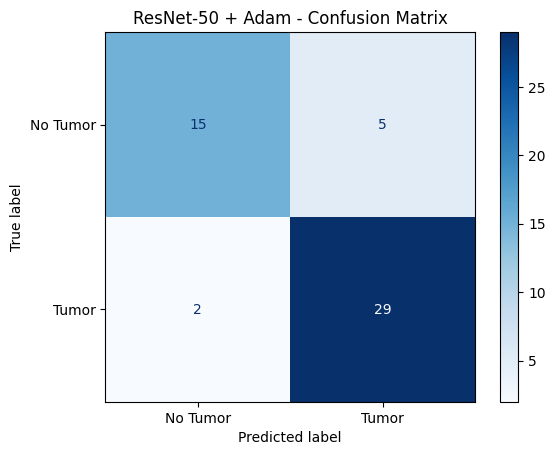

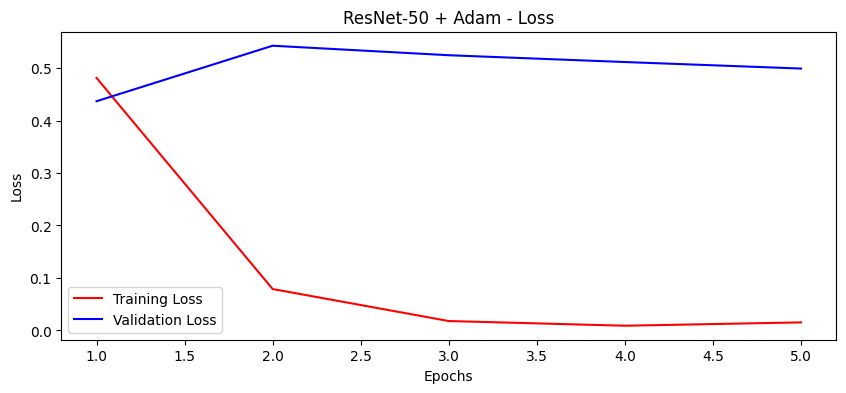

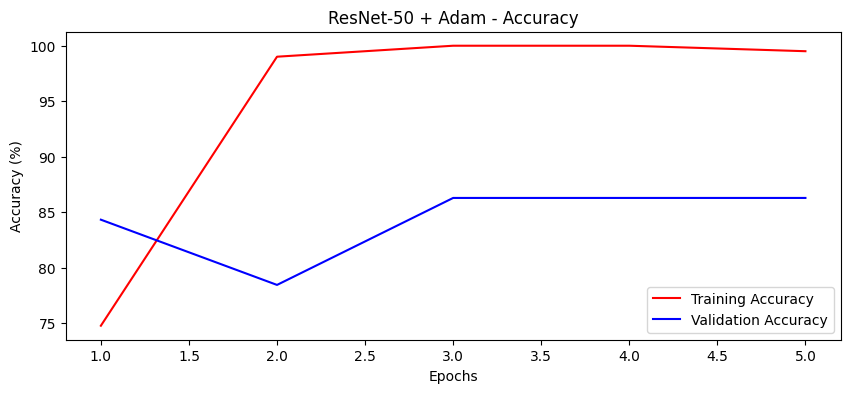

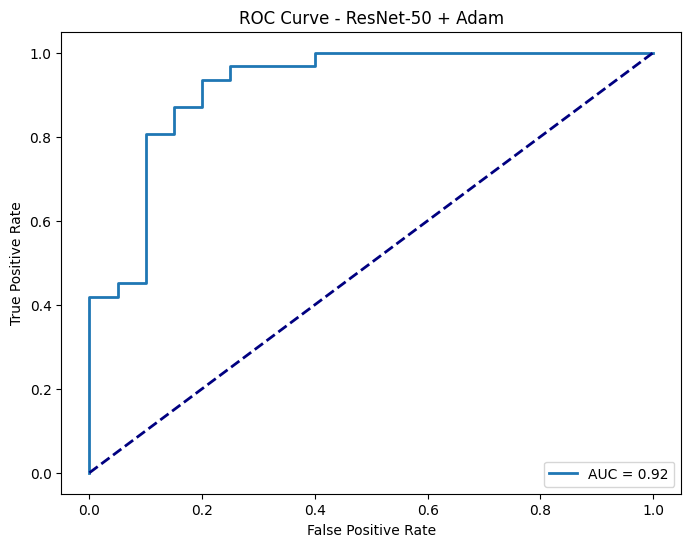


================== ResNet-50 + Rough Fuzzy ==================


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5] - ResNet-50 + Rough Fuzzy | Train Loss: 0.7092, Train Acc: 60.89% | Val Loss: 0.6463, Val Acc: 60.78%
Epoch [2/5] - ResNet-50 + Rough Fuzzy | Train Loss: 0.6722, Train Acc: 59.41% | Val Loss: 0.6759, Val Acc: 62.75%
Epoch [3/5] - ResNet-50 + Rough Fuzzy | Train Loss: 0.6886, Train Acc: 59.41% | Val Loss: 0.6996, Val Acc: 62.75%
Epoch [4/5] - ResNet-50 + Rough Fuzzy | Train Loss: 0.6726, Train Acc: 62.87% | Val Loss: 0.7120, Val Acc: 60.78%
Epoch [5/5] - ResNet-50 + Rough Fuzzy | Train Loss: 0.6664, Train Acc: 63.37% | Val Loss: 0.7184, Val Acc: 62.75%

ResNet-50 + Rough Fuzzy - Accuracy: 62.75%
Precision: 0.62, Recall: 0.54, F1: 0.50, Inference Time: 3.9829s

Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.60      0.15      0.24        20
       Tumor       0.63      0.94      0.75        31

    accuracy                           0.63        51
   macro avg       0.62      0.54      0.50        51
weighted avg       0.62  

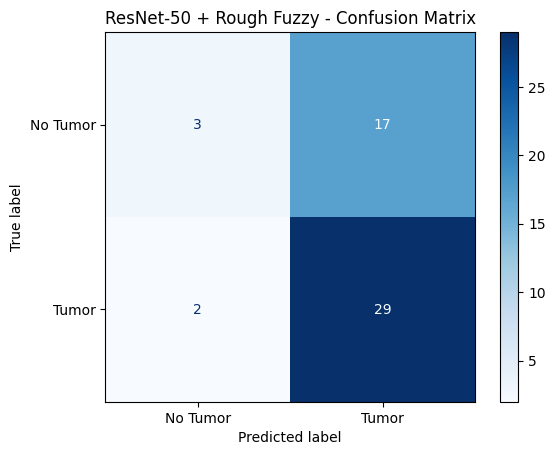

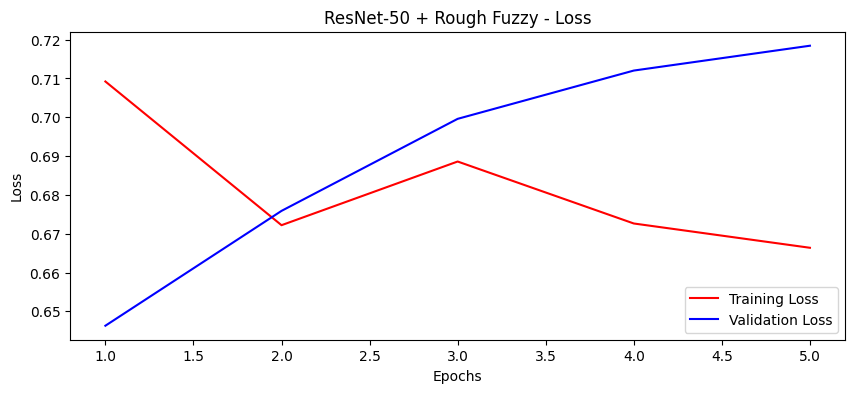

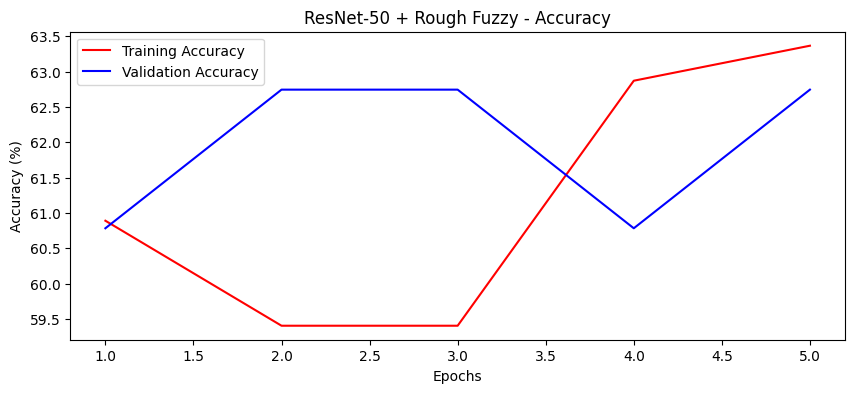

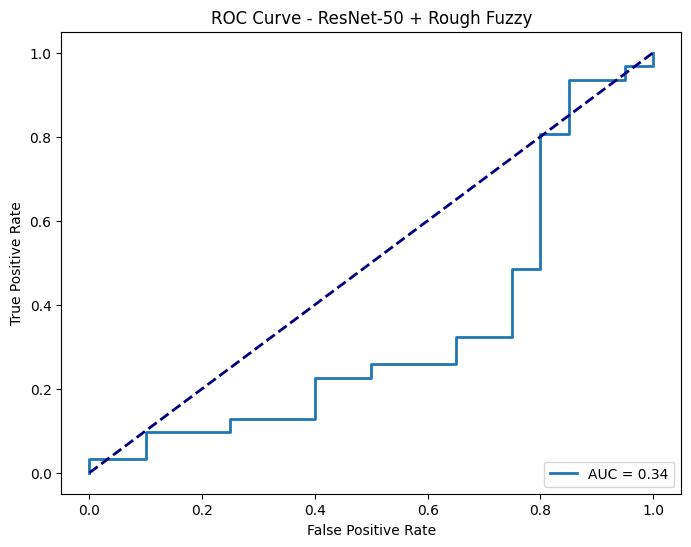

In [32]:
run_model_experiments(ResNetModel,   "ResNet-50",  num_epochs=5, lr=1e-4)


====================== GoogleNet + Adam ======================
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 138MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


Epoch [1/5] - GoogleNet + Adam | Train Loss: 0.6089, Train Acc: 64.85% | Val Loss: 0.5999, Val Acc: 70.59%
Epoch [2/5] - GoogleNet + Adam | Train Loss: 0.2840, Train Acc: 90.10% | Val Loss: 0.4103, Val Acc: 82.35%
Epoch [3/5] - GoogleNet + Adam | Train Loss: 0.1550, Train Acc: 97.52% | Val Loss: 0.3355, Val Acc: 86.27%
Epoch [4/5] - GoogleNet + Adam | Train Loss: 0.0932, Train Acc: 100.00% | Val Loss: 0.3217, Val Acc: 88.24%
Epoch [5/5] - GoogleNet + Adam | Train Loss: 0.0976, Train Acc: 99.50% | Val Loss: 0.3073, Val Acc: 86.27%

GoogleNet + Adam - Accuracy: 86.27%
Precision: 0.88, Recall: 0.83, F1: 0.85, Inference Time: 1.9289s

Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.93      0.70      0.80        20
       Tumor       0.83      0.97      0.90        31

    accuracy                           0.86        51
   macro avg       0.88      0.83      0.85        51
weighted avg       0.87      0.86      0.86        51



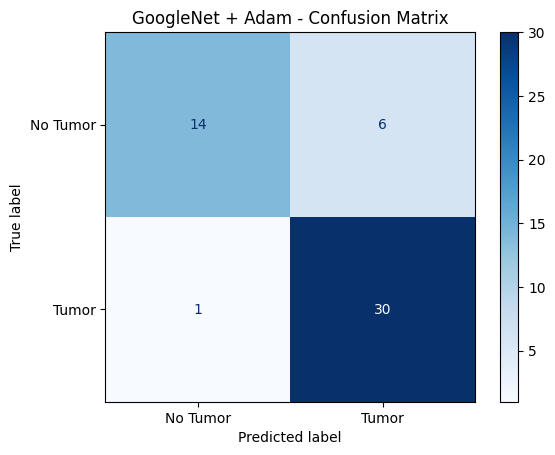

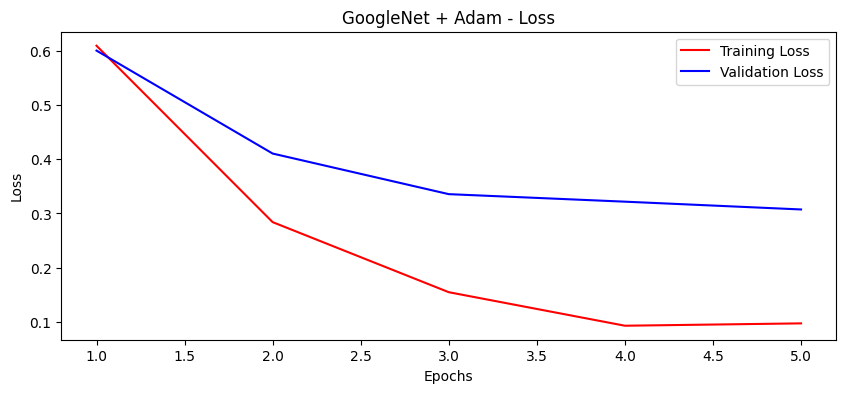

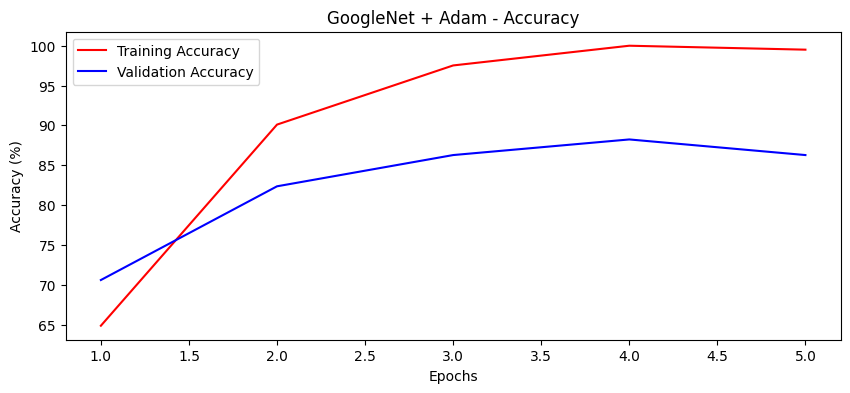

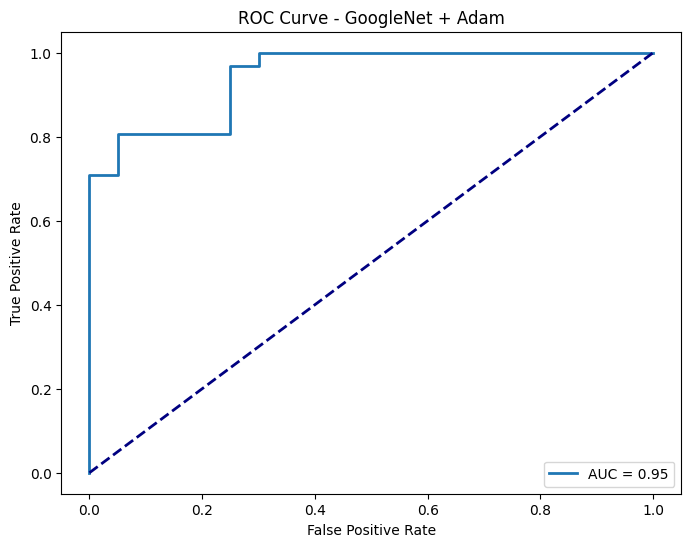


================== GoogleNet + Rough Fuzzy ==================


/usr/local/lib/python3.12/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


Epoch [1/5] - GoogleNet + Rough Fuzzy | Train Loss: 0.7686, Train Acc: 45.05% | Val Loss: 0.8513, Val Acc: 35.29%
Epoch [2/5] - GoogleNet + Rough Fuzzy | Train Loss: 0.7744, Train Acc: 45.54% | Val Loss: 0.8082, Val Acc: 41.18%
Epoch [3/5] - GoogleNet + Rough Fuzzy | Train Loss: 0.7519, Train Acc: 43.07% | Val Loss: 0.7893, Val Acc: 43.14%
Epoch [4/5] - GoogleNet + Rough Fuzzy | Train Loss: 0.7655, Train Acc: 42.57% | Val Loss: 0.7765, Val Acc: 45.10%
Epoch [5/5] - GoogleNet + Rough Fuzzy | Train Loss: 0.7322, Train Acc: 45.05% | Val Loss: 0.7600, Val Acc: 45.10%

GoogleNet + Rough Fuzzy - Accuracy: 45.10%
Precision: 0.61, Recall: 0.54, F1: 0.40, Inference Time: 1.9430s

Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.41      0.95      0.58        20
       Tumor       0.80      0.13      0.22        31

    accuracy                           0.45        51
   macro avg       0.61      0.54      0.40        51
weighted avg       0.65  

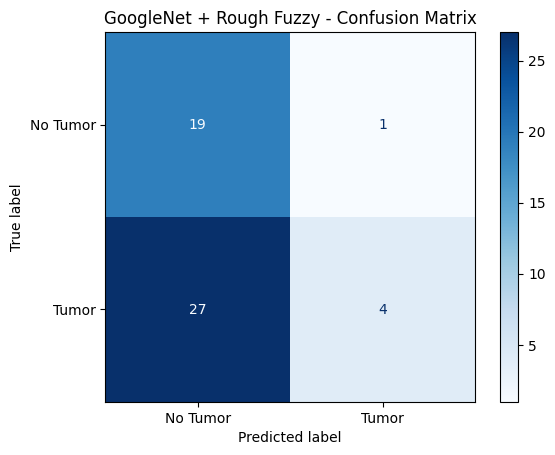

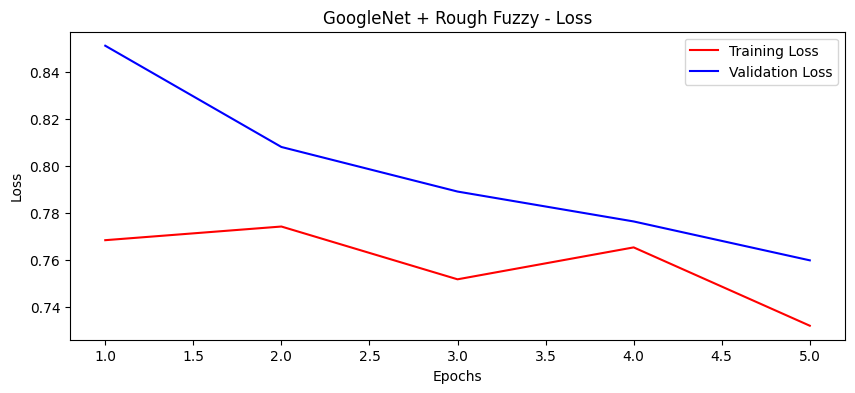

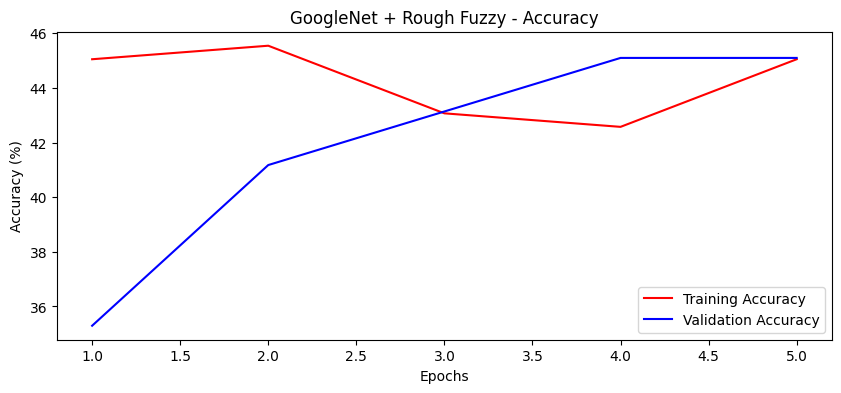

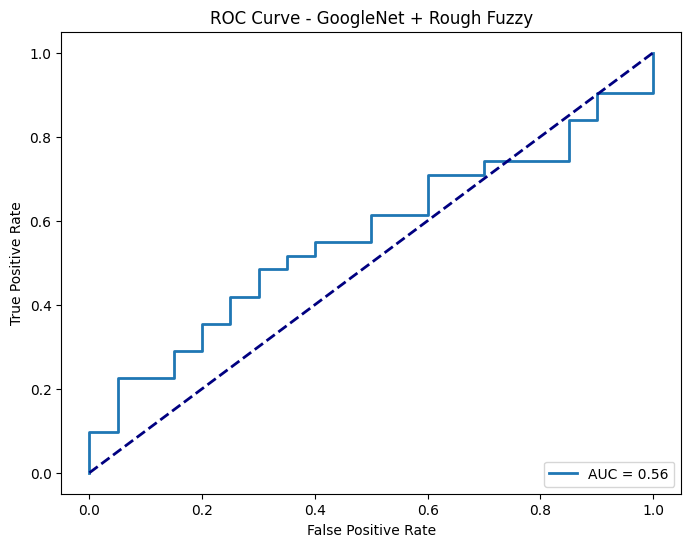

In [37]:
run_model_experiments(GoogleNetModel,"GoogleNet",  num_epochs=5, lr=1e-4)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



====================== MobileNetV2 + Adam ======================
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 99.3MB/s]


Epoch [1/5] - MobileNetV2 + Adam | Train Loss: 0.5475, Train Acc: 70.79% | Val Loss: 0.5563, Val Acc: 70.59%
Epoch [2/5] - MobileNetV2 + Adam | Train Loss: 0.2159, Train Acc: 95.05% | Val Loss: 0.3828, Val Acc: 86.27%
Epoch [3/5] - MobileNetV2 + Adam | Train Loss: 0.1115, Train Acc: 97.52% | Val Loss: 0.4564, Val Acc: 86.27%
Epoch [4/5] - MobileNetV2 + Adam | Train Loss: 0.0410, Train Acc: 99.50% | Val Loss: 0.5495, Val Acc: 88.24%
Epoch [5/5] - MobileNetV2 + Adam | Train Loss: 0.0230, Train Acc: 100.00% | Val Loss: 0.5825, Val Acc: 88.24%

MobileNetV2 + Adam - Accuracy: 88.24%
Precision: 0.92, Recall: 0.85, F1: 0.87, Inference Time: 0.5023s

Classification Report:
              precision    recall  f1-score   support

    No Tumor       1.00      0.70      0.82        20
       Tumor       0.84      1.00      0.91        31

    accuracy                           0.88        51
   macro avg       0.92      0.85      0.87        51
weighted avg       0.90      0.88      0.88        51


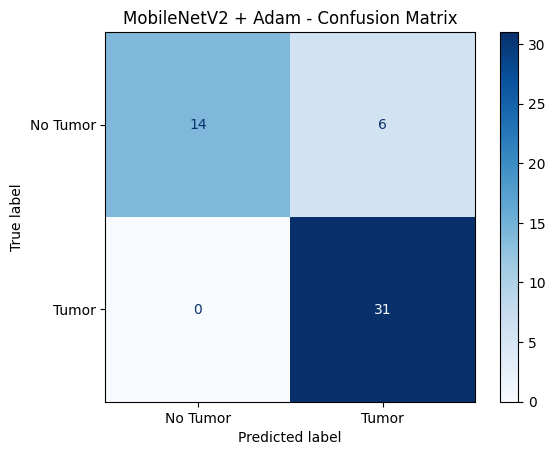

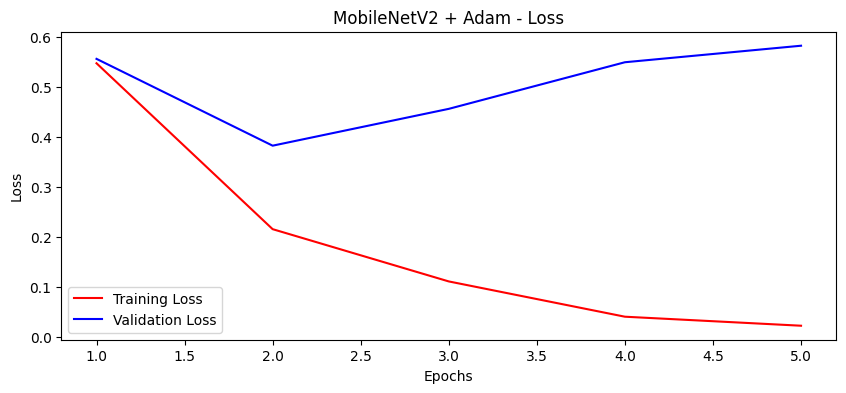

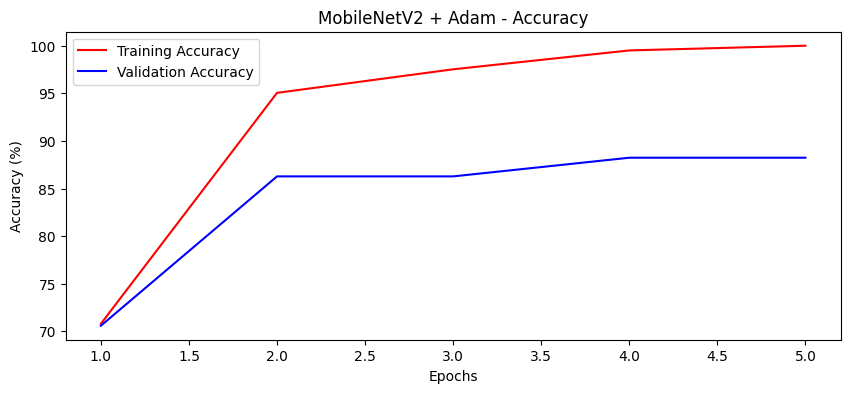

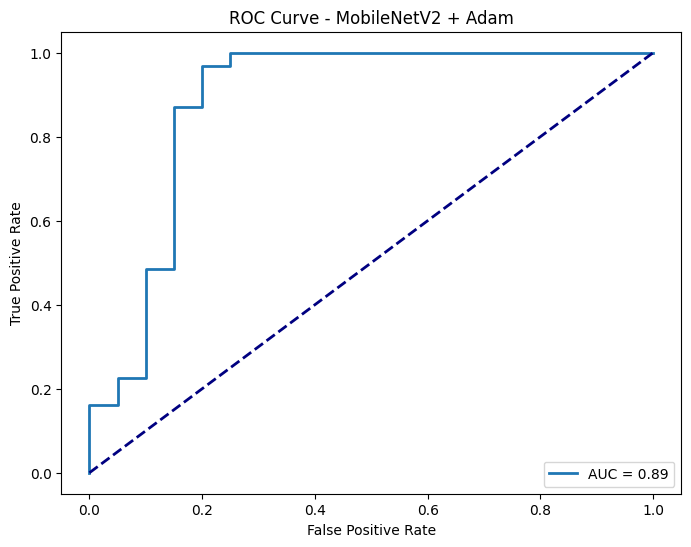


================== MobileNetV2 + Rough Fuzzy ==================


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5] - MobileNetV2 + Rough Fuzzy | Train Loss: 0.6673, Train Acc: 58.91% | Val Loss: 0.6440, Val Acc: 60.78%
Epoch [2/5] - MobileNetV2 + Rough Fuzzy | Train Loss: 0.6642, Train Acc: 59.90% | Val Loss: 0.6689, Val Acc: 60.78%
Epoch [3/5] - MobileNetV2 + Rough Fuzzy | Train Loss: 0.6868, Train Acc: 57.92% | Val Loss: 0.6651, Val Acc: 58.82%
Epoch [4/5] - MobileNetV2 + Rough Fuzzy | Train Loss: 0.6786, Train Acc: 60.40% | Val Loss: 0.6648, Val Acc: 60.78%
Epoch [5/5] - MobileNetV2 + Rough Fuzzy | Train Loss: 0.6678, Train Acc: 62.38% | Val Loss: 0.6411, Val Acc: 62.75%

MobileNetV2 + Rough Fuzzy - Accuracy: 62.75%
Precision: 0.81, Recall: 0.53, F1: 0.43, Inference Time: 0.5220s

Classification Report:
              precision    recall  f1-score   support

    No Tumor       1.00      0.05      0.10        20
       Tumor       0.62      1.00      0.77        31

    accuracy                           0.63        51
   macro avg       0.81      0.53      0.43        51
weighted avg 

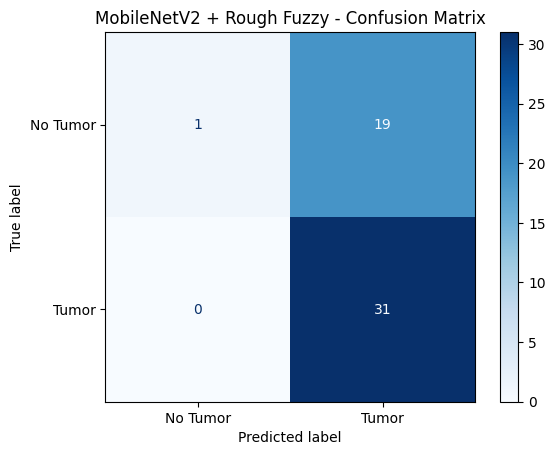

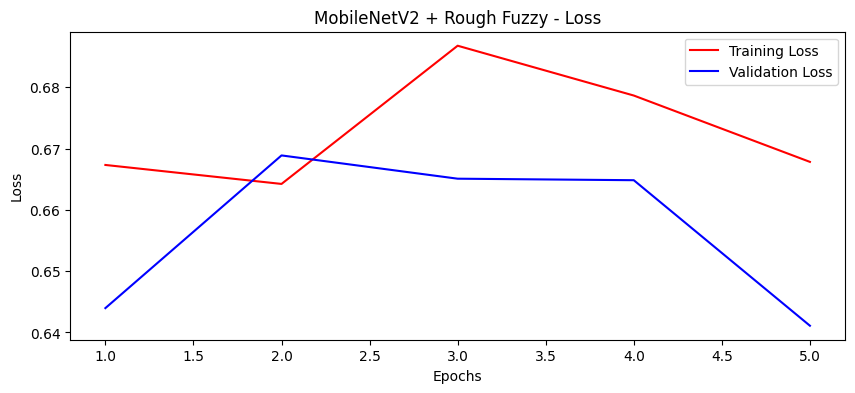

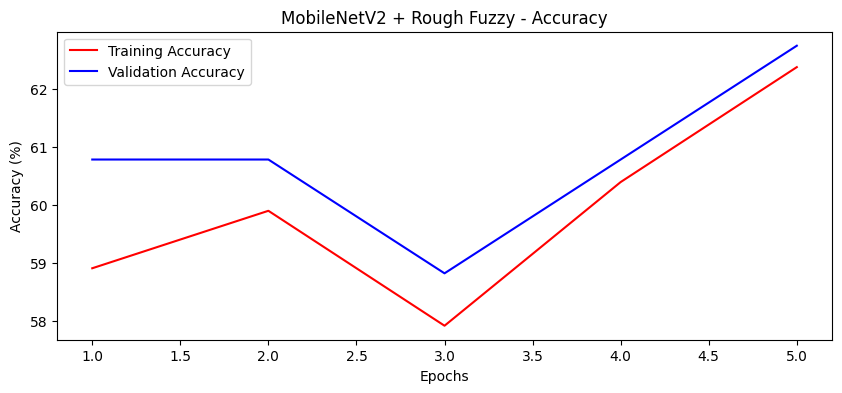

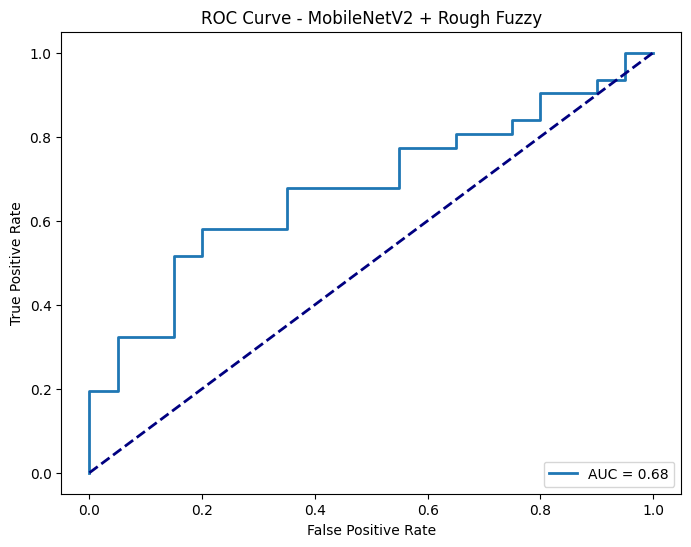

In [35]:
run_model_experiments(MobileNetModel,"MobileNetV2",num_epochs=5, lr=1e-4)


====================== VGG16 + Adam ======================


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:09<00:00, 57.5MB/s]


Epoch [1/5] - VGG16 + Adam | Train Loss: 0.7772, Train Acc: 58.42% | Val Loss: 0.6216, Val Acc: 68.63%
Epoch [2/5] - VGG16 + Adam | Train Loss: 0.4598, Train Acc: 77.72% | Val Loss: 0.4476, Val Acc: 86.27%
Epoch [3/5] - VGG16 + Adam | Train Loss: 0.2320, Train Acc: 91.09% | Val Loss: 0.4749, Val Acc: 84.31%
Epoch [4/5] - VGG16 + Adam | Train Loss: 0.1681, Train Acc: 92.57% | Val Loss: 0.5186, Val Acc: 82.35%
Epoch [5/5] - VGG16 + Adam | Train Loss: 0.0453, Train Acc: 98.51% | Val Loss: 0.6555, Val Acc: 84.31%

VGG16 + Adam - Accuracy: 84.31%
Precision: 0.84, Recall: 0.83, F1: 0.83, Inference Time: 10.1557s

Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.83      0.75      0.79        20
       Tumor       0.85      0.90      0.88        31

    accuracy                           0.84        51
   macro avg       0.84      0.83      0.83        51
weighted avg       0.84      0.84      0.84        51



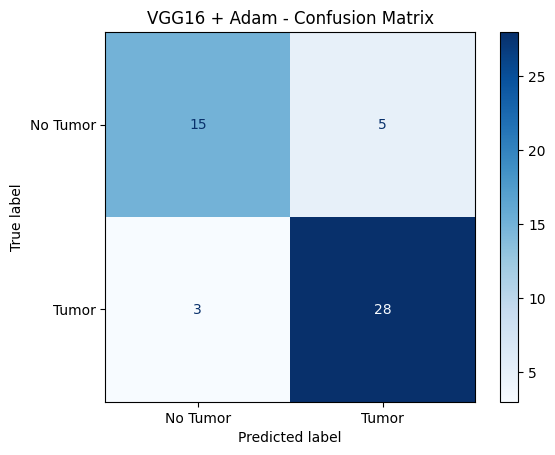

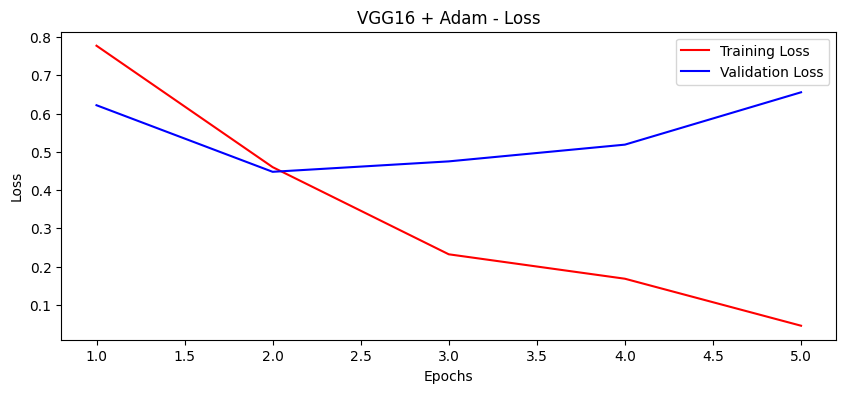

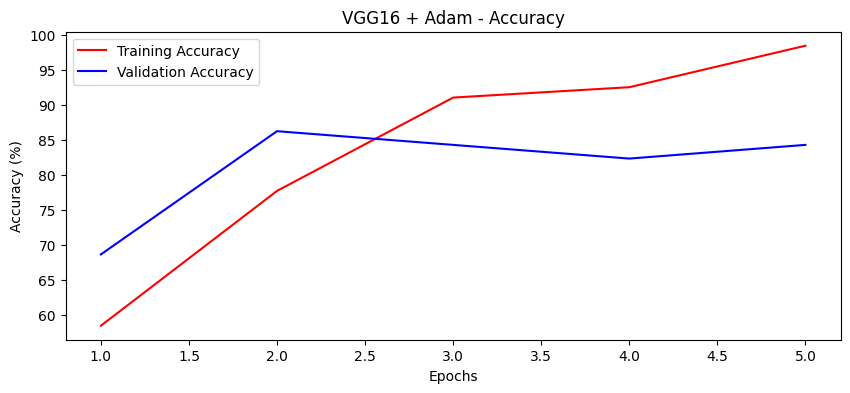

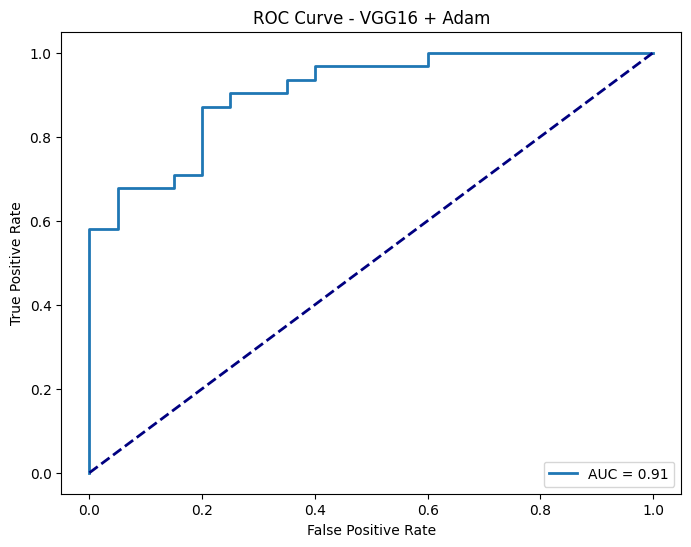


================== VGG16 + Rough Fuzzy ==================


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5] - VGG16 + Rough Fuzzy | Train Loss: 0.7707, Train Acc: 51.98% | Val Loss: 0.7120, Val Acc: 52.94%
Epoch [2/5] - VGG16 + Rough Fuzzy | Train Loss: 0.7883, Train Acc: 43.56% | Val Loss: 0.6834, Val Acc: 52.94%
Epoch [3/5] - VGG16 + Rough Fuzzy | Train Loss: 0.6738, Train Acc: 57.92% | Val Loss: 0.6648, Val Acc: 52.94%
Epoch [4/5] - VGG16 + Rough Fuzzy | Train Loss: 0.7782, Train Acc: 48.51% | Val Loss: 0.6480, Val Acc: 64.71%
Epoch [5/5] - VGG16 + Rough Fuzzy | Train Loss: 0.7277, Train Acc: 55.45% | Val Loss: 0.6375, Val Acc: 62.75%

VGG16 + Rough Fuzzy - Accuracy: 62.75%
Precision: 0.62, Recall: 0.54, F1: 0.50, Inference Time: 11.0593s

Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.60      0.15      0.24        20
       Tumor       0.63      0.94      0.75        31

    accuracy                           0.63        51
   macro avg       0.62      0.54      0.50        51
weighted avg       0.62      0.63      0.55     

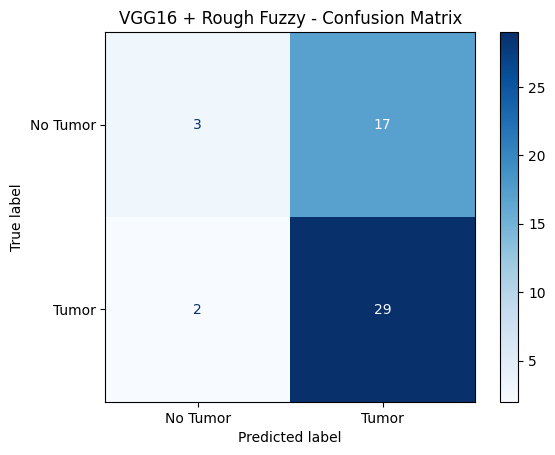

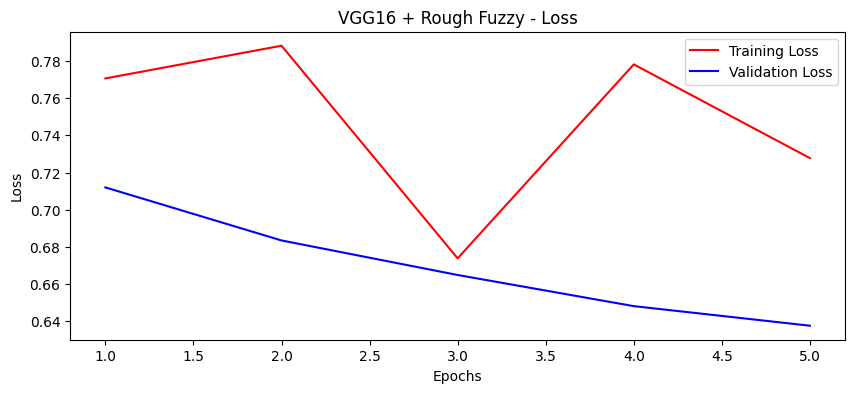

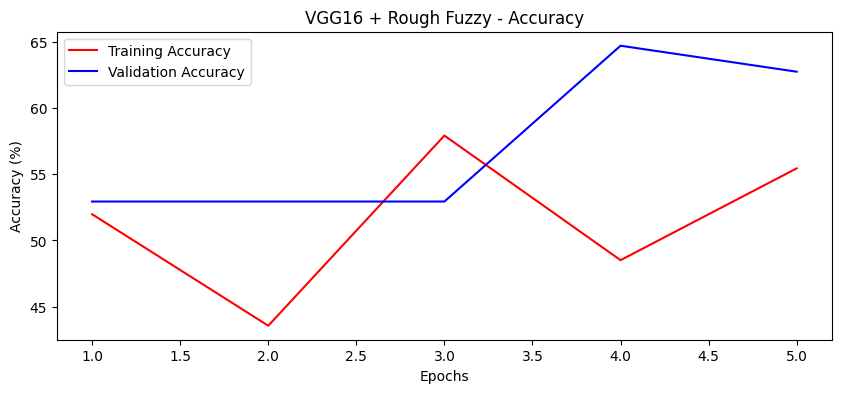

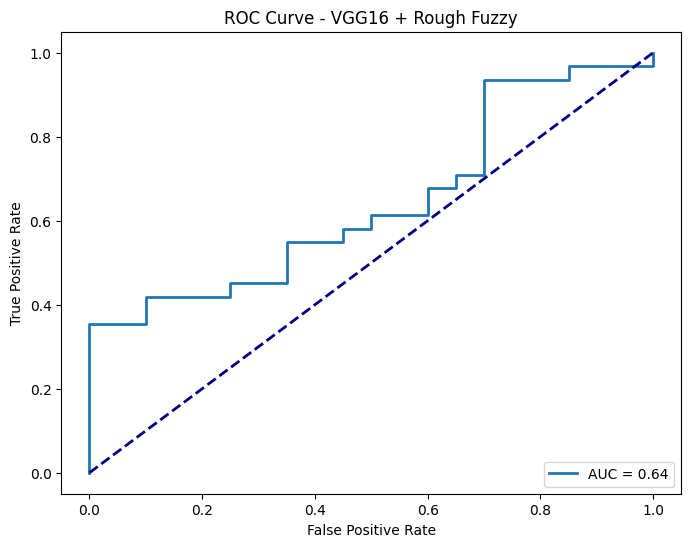

In [38]:
run_model_experiments(VGG16Model,    "VGG16",      num_epochs=5, lr=1e-4)


====================== AlexNet + Adam ======================


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 157MB/s]


Epoch [1/5] - AlexNet + Adam | Train Loss: 0.9026, Train Acc: 62.87% | Val Loss: 0.5693, Val Acc: 70.59%
Epoch [2/5] - AlexNet + Adam | Train Loss: 0.4899, Train Acc: 74.75% | Val Loss: 0.4088, Val Acc: 82.35%
Epoch [3/5] - AlexNet + Adam | Train Loss: 0.3668, Train Acc: 84.16% | Val Loss: 0.4991, Val Acc: 80.39%
Epoch [4/5] - AlexNet + Adam | Train Loss: 0.2167, Train Acc: 93.07% | Val Loss: 0.4692, Val Acc: 84.31%
Epoch [5/5] - AlexNet + Adam | Train Loss: 0.1130, Train Acc: 97.03% | Val Loss: 0.6464, Val Acc: 86.27%

AlexNet + Adam - Accuracy: 86.27%
Precision: 0.91, Recall: 0.82, F1: 0.84, Inference Time: 0.6596s

Classification Report:
              precision    recall  f1-score   support

    No Tumor       1.00      0.65      0.79        20
       Tumor       0.82      1.00      0.90        31

    accuracy                           0.86        51
   macro avg       0.91      0.82      0.84        51
weighted avg       0.89      0.86      0.86        51



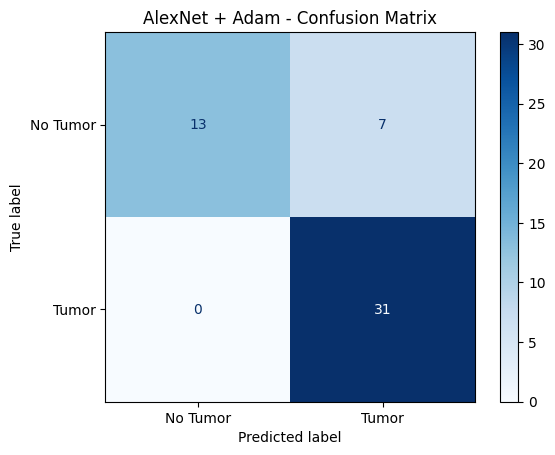

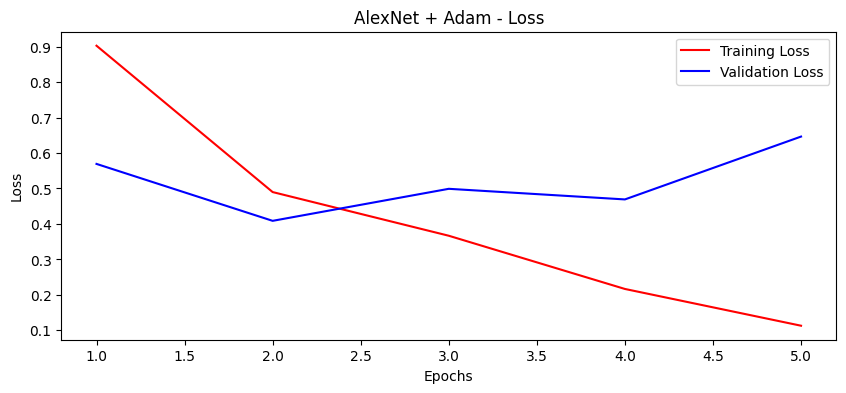

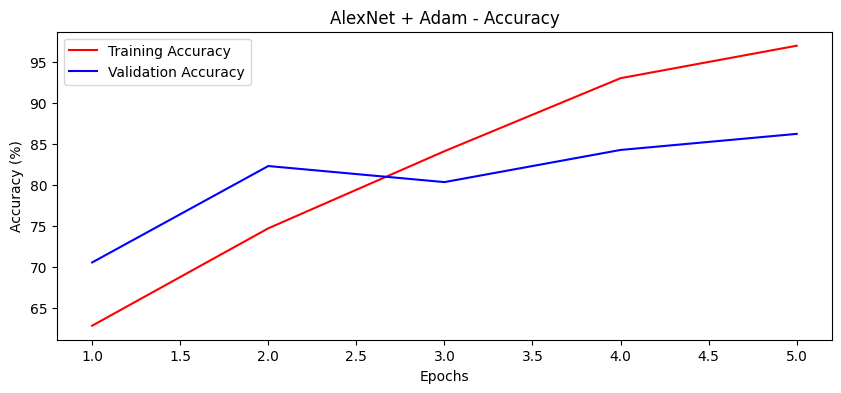

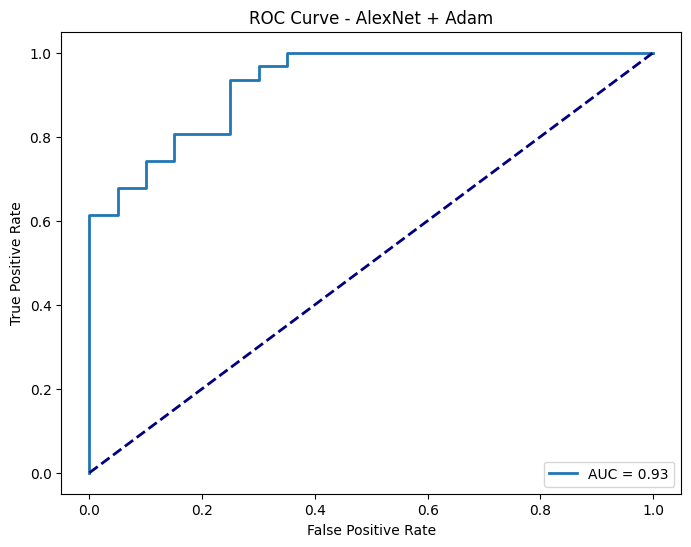


================== AlexNet + Rough Fuzzy ==================


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5] - AlexNet + Rough Fuzzy | Train Loss: 0.7917, Train Acc: 48.51% | Val Loss: 0.6467, Val Acc: 60.78%
Epoch [2/5] - AlexNet + Rough Fuzzy | Train Loss: 0.7268, Train Acc: 53.47% | Val Loss: 0.6265, Val Acc: 62.75%
Epoch [3/5] - AlexNet + Rough Fuzzy | Train Loss: 0.7561, Train Acc: 51.98% | Val Loss: 0.6070, Val Acc: 62.75%
Epoch [4/5] - AlexNet + Rough Fuzzy | Train Loss: 0.7286, Train Acc: 56.93% | Val Loss: 0.5931, Val Acc: 62.75%
Epoch [5/5] - AlexNet + Rough Fuzzy | Train Loss: 0.6843, Train Acc: 61.88% | Val Loss: 0.5770, Val Acc: 70.59%

AlexNet + Rough Fuzzy - Accuracy: 70.59%
Precision: 0.69, Recall: 0.67, F1: 0.67, Inference Time: 0.6078s

Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.67      0.50      0.57        20
       Tumor       0.72      0.84      0.78        31

    accuracy                           0.71        51
   macro avg       0.69      0.67      0.67        51
weighted avg       0.70      0.71    

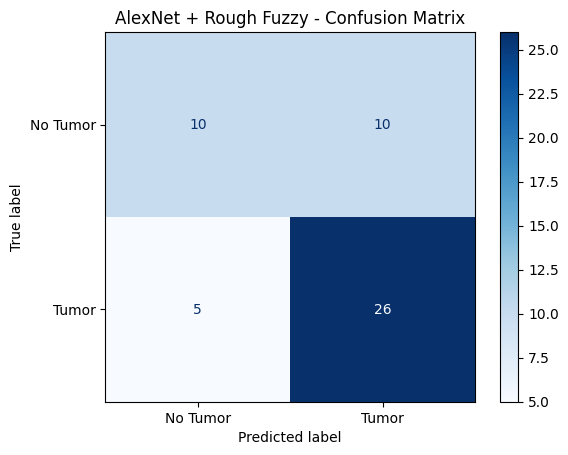

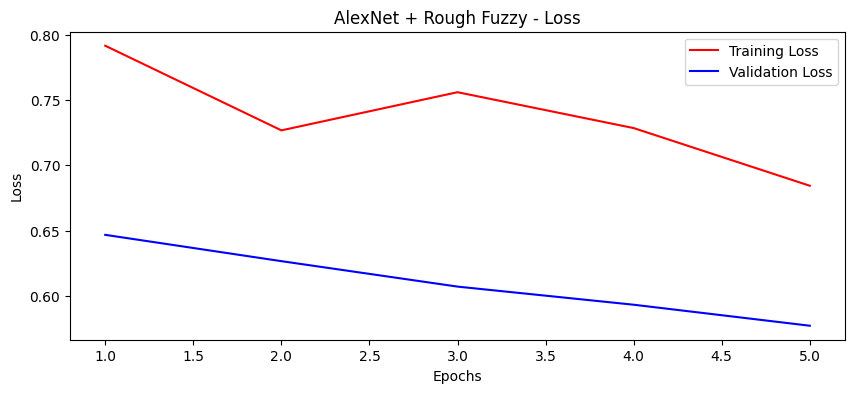

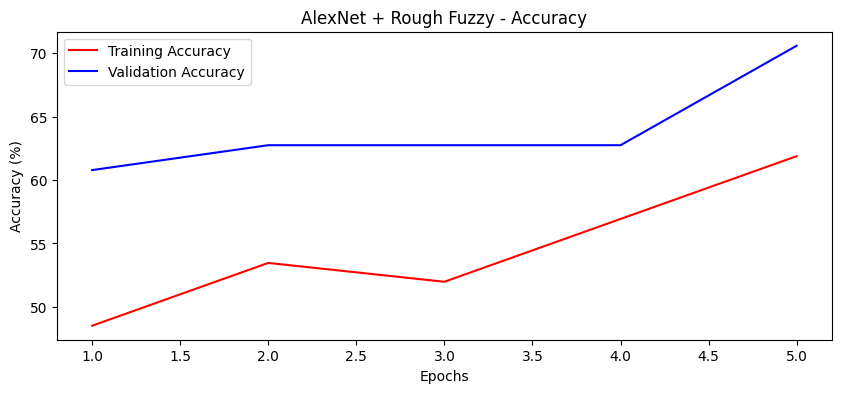

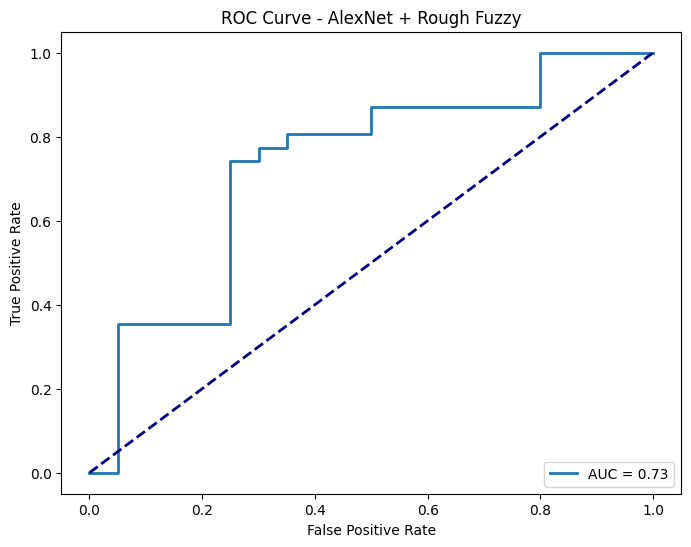

In [39]:
run_model_experiments(AlexNetModel,  "AlexNet",    num_epochs=5, lr=1e-4)